In [44]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from tqdm.auto import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [45]:
sigma = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
dataset = torchvision.datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [46]:
def training_loop(model, dataloader, optimizer, num_epochs, device=device):
    """Training loop for Score Matching"""

    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)

            noisy = model.add_noise(batch, noise)
            noise_pred = model(noisy)
            loss = F.mse_loss(noise_pred, torch.flatten(batch, start_dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        progress_bar.close()

In [47]:
class Encoder_Decoder(nn.Module):
    # The encoder and decoder, each have only one linear layer, and the weight matrix have the relation W1^{T} = DW2
    # D is also the trainable parameter in our network

    def __init__(self, hidden_dim, sigma) -> None:
        super().__init__()
        self.encoder = nn.Linear(28*28, hidden_dim)
        weight_matrix = self.encoder.weight
        self.decoder = nn.Linear(hidden_dim, 28*28)
        self.D = nn.Parameter(torch.ones((1, hidden_dim)), requires_grad=True)
        self.decoder.weight.data = weight_matrix.T
        self.sigmoid = nn.Sigmoid()
        self.sigma = sigma

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        encode = self.sigmoid(self.encoder(x))
        encode = encode * self.D
        decode = self.decoder(encode)
        return decode
    
    def add_noise(self, x, noise):
        # Add gaussian noise
        return x + noise * self.sigma        
    
    def energy_function(self, x):
        # calculate the energy function with equiation (1) in the report
        x = torch.flatten(x, start_dim=0)
        input = self.encoder(x)
        softplus = torch.log(1 + torch.exp(input))
        energy = torch.sum(self.D*softplus, dim=-1) - 0.5*torch.dot(x, x) + torch.dot(self.decoder.bias, x)
        return -energy/(self.sigma**2)

In [48]:
model = Encoder_Decoder(100, sigma)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, 500, device=device)

Epoch 499: 100%|██████████| 469/469 [00:04<00:00, 114.41it/s, loss=0.00875, step=234499]


In [90]:
def show_images_energy(images, num, title="", pixel=28, channel=1):
    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = 1
    cols = num

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx].reshape(pixel, pixel, channel), cmap='gray')
                if model.energy_function(torch.tensor(images[idx])).item() != -np.inf:
                    plt.title(f"{int(model.energy_function(torch.tensor(images[idx][0])).item())}")
                else:
                    plt.title("-inf")
                idx += 1
    fig.suptitle(title, fontsize=30)
    # Showing the figure
    plt.show()

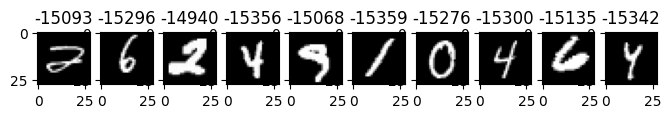

In [86]:
images = next(iter(dataloader))
images = images[0][:10,:,:,:]
show_images_energy(images, 10)

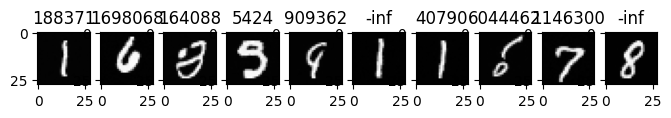

In [91]:
images = np.load("res/ddpm.npy")
images = images[:10,:,:]
show_images_energy(images, 10)

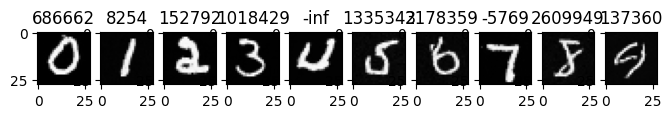

In [92]:
images = np.load("res/conditional.npy")
images = images[:10,:,:]
show_images_energy(images, 10)

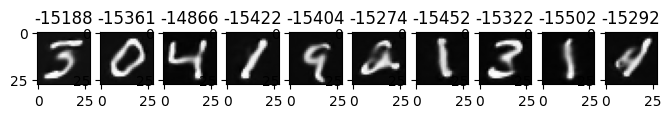

In [83]:
images = np.load("res/cold_resolution2.npy")
images = images[:10,:,:]
show_images_energy(images, 10)

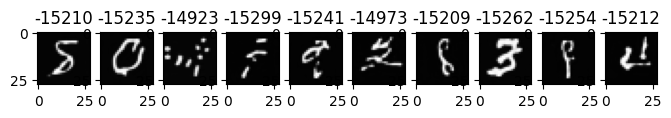

In [88]:
images = np.load("res/cold_kernel1.npy")
images = images[:10,:,:]
show_images_energy(images, 10)

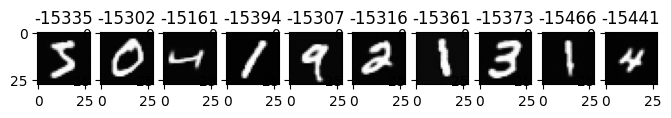

In [87]:
images = np.load("res/cold_median2.npy")
images = images[:10,:,:]
show_images_energy(images, 10)